In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\SAGAR\\Downloads\\Tomato_Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [5]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

501

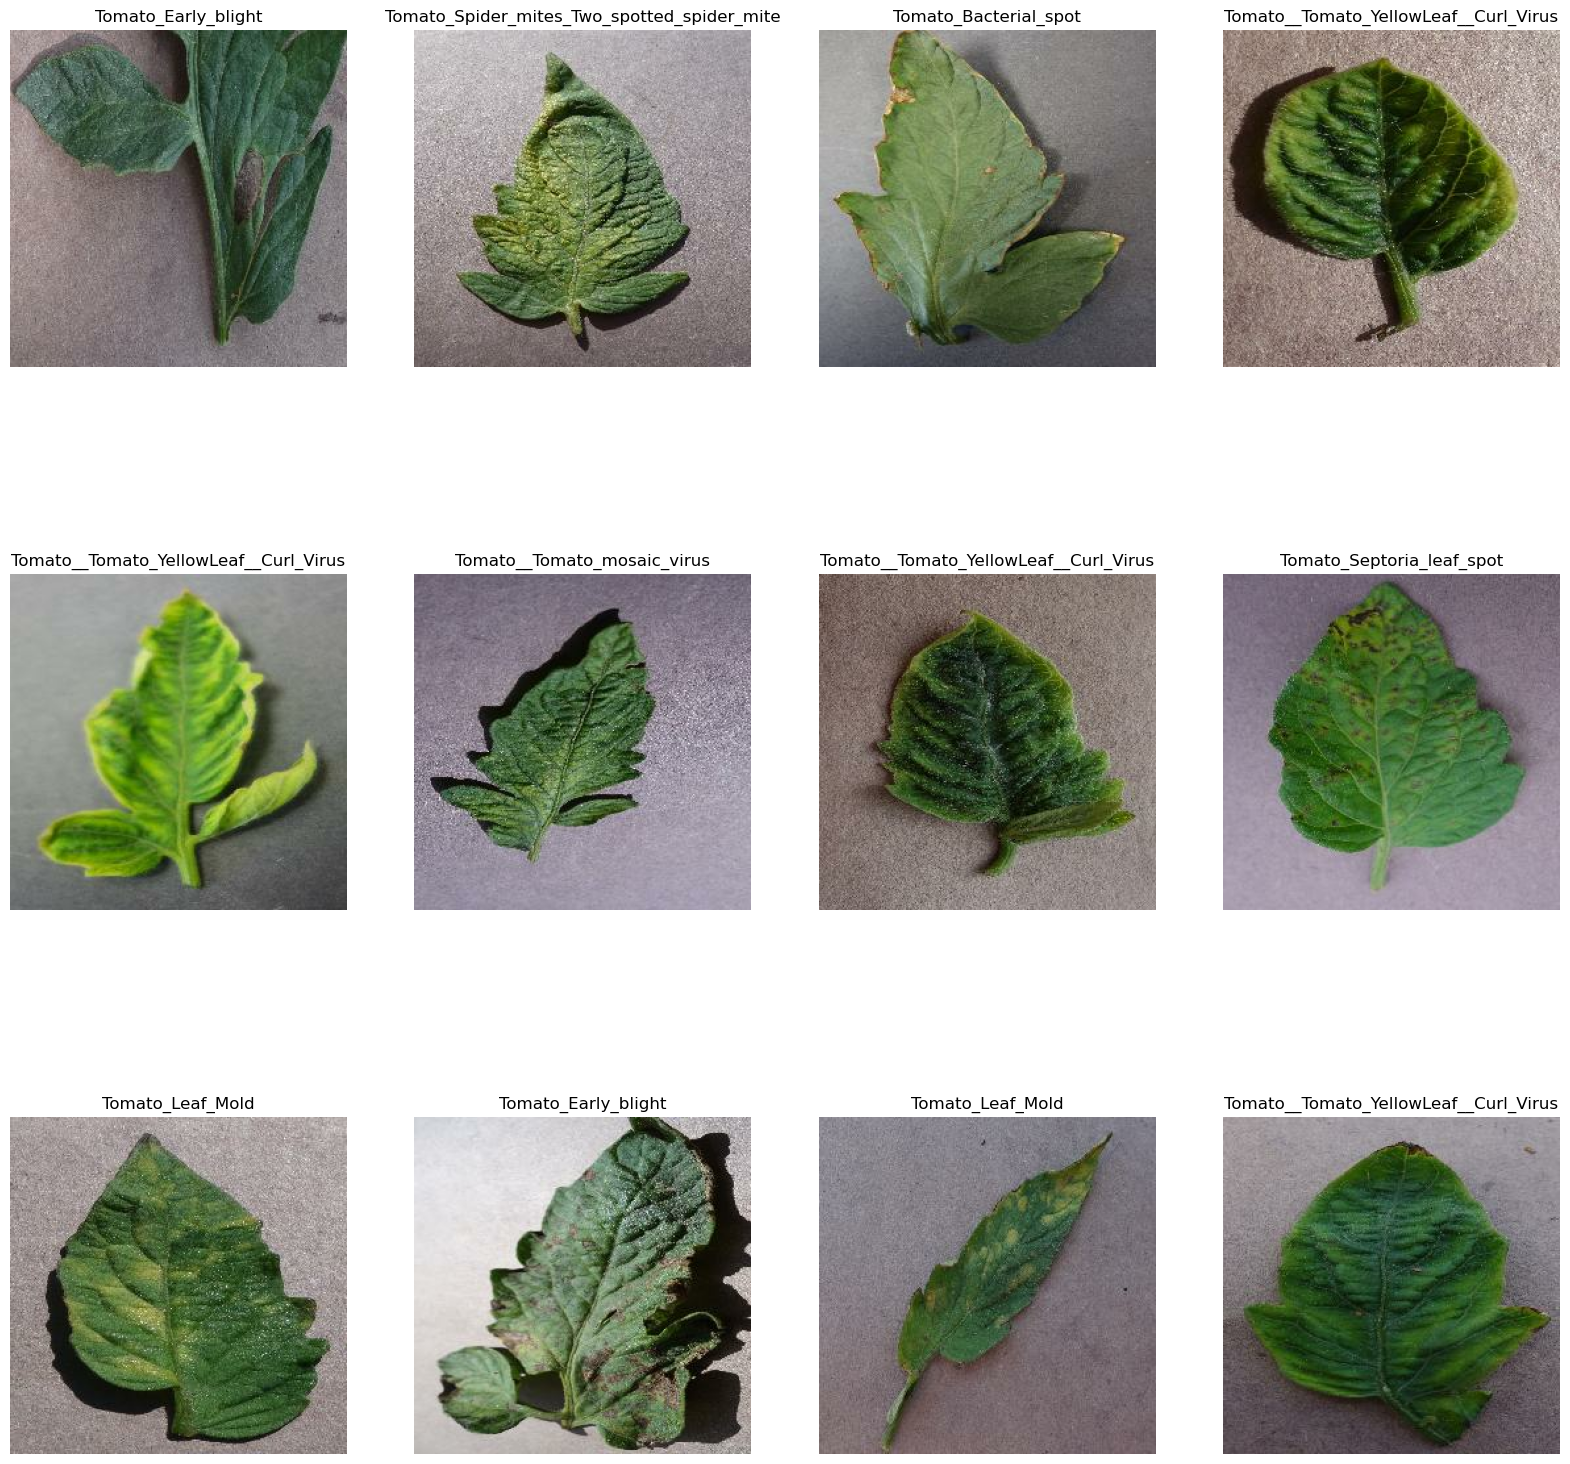

In [7]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
train_size=0.8
len(dataset)*train_size

400.8

In [9]:
train_ds=dataset.take(400)
len(train_ds)

400

In [10]:
test_ds=dataset.skip(400)
len(test_ds)

101

In [11]:
val_size=0.1
len(dataset)*val_size

50.1

In [12]:
val_ds=test_ds.take(50)
len(val_ds)

50

In [13]:
test_ds=test_ds.skip(50)
len(test_ds)

51

In [14]:
#fun. for doing above work
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
     
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

400

In [17]:
len(test_ds)

51

In [18]:
#prefetch is used to make CPU and GPU work parallel(Optimal use of hardware resources)
#cache does open,read,map in first epoch and in further epocs it just train the model
train_ds=train_ds.cache() .shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
#Converting RGB scale which is betn 0 to 255 into 0 to 1.
#Resizing will take care if the particular data which is not of ideal size(256X256)
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [20]:
#To make our model robust
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [23]:
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
# Define the parameters
n_classes = 10

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the model
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Flatten(),  # Flattening the input
    layers.Dense(128, activation='relu'),  # Dense layer with 128 units
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),   # Dense layer with 64 units
    layers.Dense(n_classes, activation='softmax')  # Output layer with softmax activation
])


# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 196608)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      25,165,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,174,858 (96.03 MB)

 Trainable params: 25,174,858 (96.03 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 202s 497ms/step - accuracy: 0.1771 - loss: 2.7374 - val_accuracy: 0.2206 - val_loss: 1.9771
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 195s 486ms/step - accuracy: 0.2040 - loss: 2.1545 - val_accuracy: 0.2188 - val_loss: 2.0424
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 196s 489ms/step - accuracy: 0.2082 - loss: 2.1105 - val_accuracy: 0.2175 - val_loss: 2.0034
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 192s 480ms/step - accuracy: 0.2047 - loss: 2.0883 - val_accuracy: 0.2175 - val_loss: 1.9950
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 191s 478ms/step - accuracy: 0.2127 - loss: 2.0702 - val_accuracy: 0.2225 - val_loss: 1.9085
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 195s 487ms/step - accuracy: 0.2083 - loss: 2.0763 - val_accuracy: 0.2188 - val_loss: 1.9679
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 205s 513ms/step - accuracy: 0.2080 - loss: 2.0757 - val_accuracy: 0.2331 - val_loss: 1.8892
Epoch 8/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 206s 515ms/step - accuracy: 0.2085 -

In [22]:
scores=model.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 135s 179ms/step - accuracy: 0.2192 - loss: 2.1673


In [23]:
scores

[2.1760802268981934, 0.20955882966518402]

In [24]:
history

In [25]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 400}

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [27]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

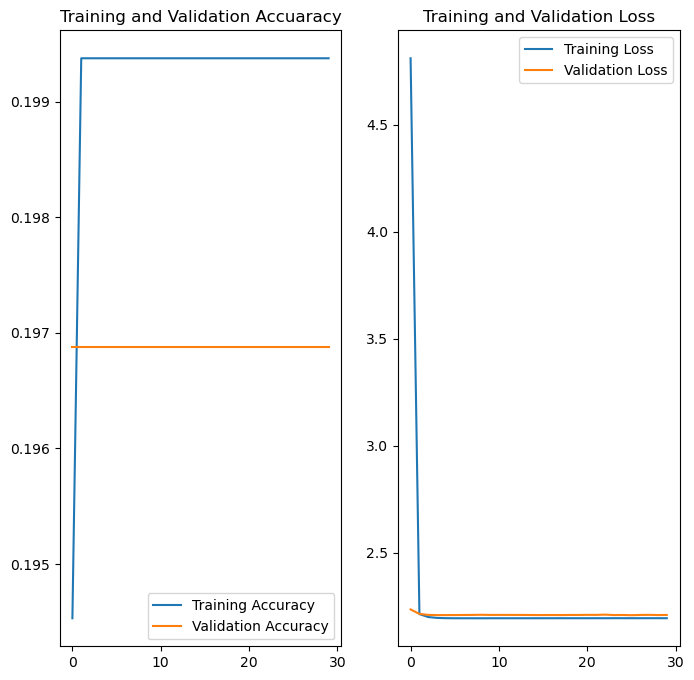

In [28]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuaracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label Tomato_Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
Predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


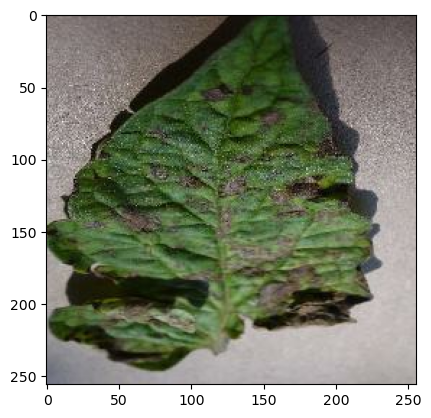

In [29]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
      
    predicted_class=class_names[np.argmax(predictions)]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


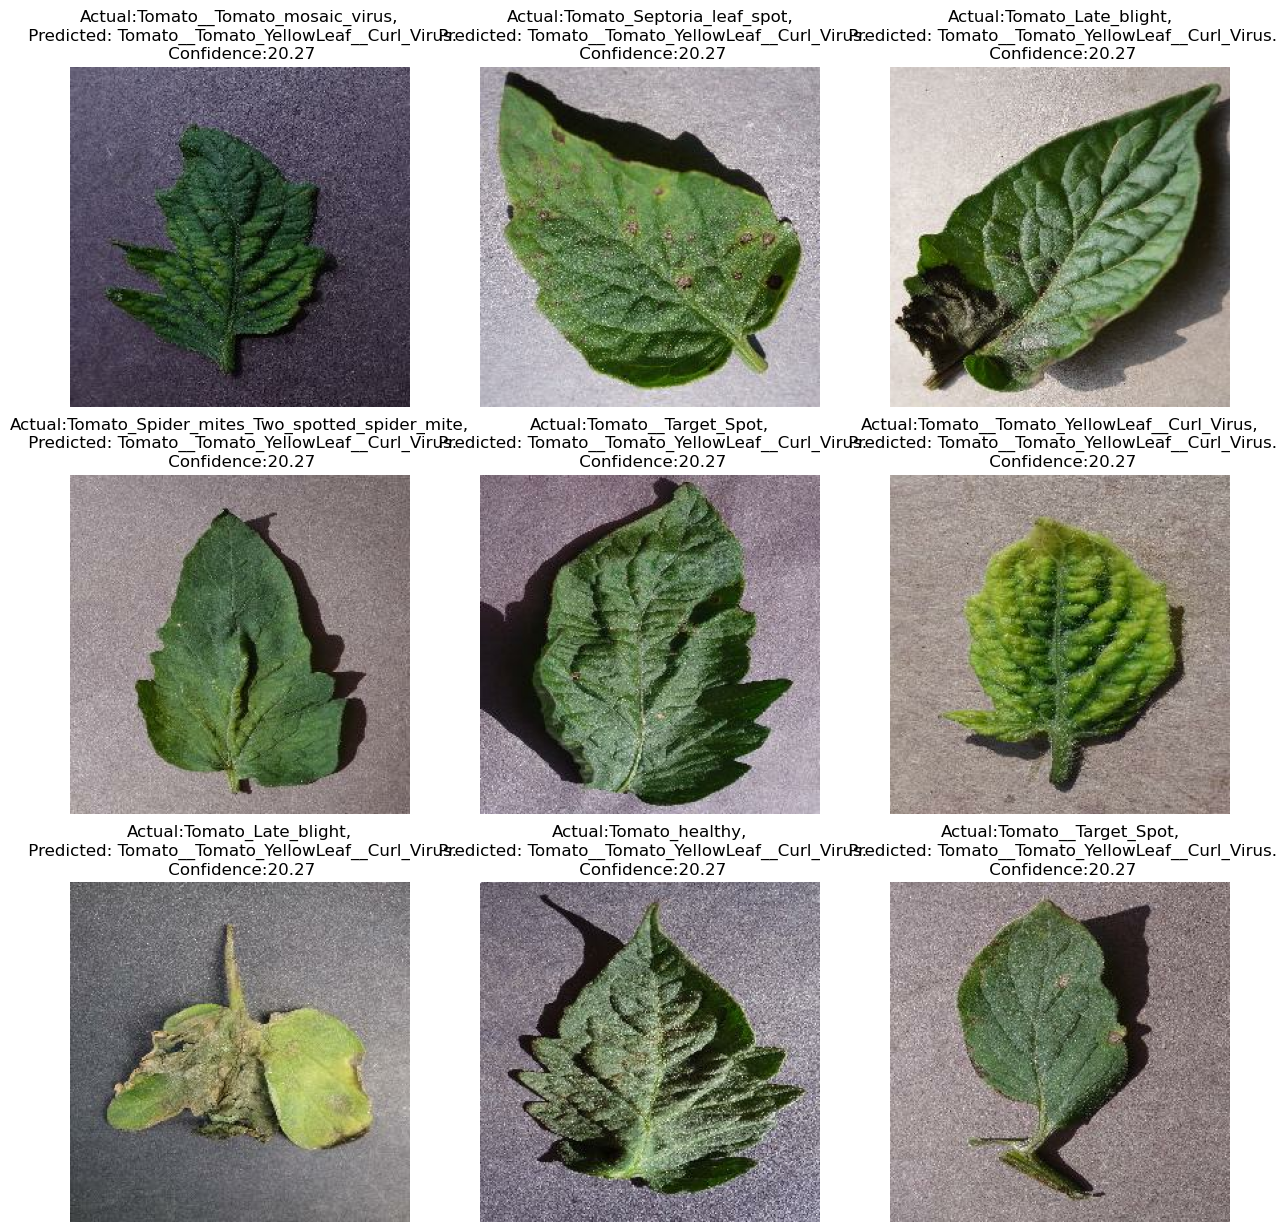

In [31]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}")
        plt.axis("off")

In [ ]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the parameters
BATCH_SIZE = 32
IMAGE_SIZE = 227  # AlexNet input size
CHANNELS = 3
n_classes = 10

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the model
model = models.Sequential([
    layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


In [ ]:
#Using CNN
#No. of layers and 32,64,... are based on trail and error.
#Softmax-Normalize the probability of classes
#MaxPooling-extract important features and reduce dimensions of data
#layers.Flatten() converts to 1D array
from tensorflow.keras import regularizers

l1_regularization = 0.01
l2_regularization = 0.01

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape,
                  kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization)),
    layers.Dense(n_classes, activation='softmax',
                 kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization))
])

model.build(input_shape=input_shape)


In [21]:
from keras import regularizers

C:\Users\SAGAR\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 10)                    │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 10)                    │             110 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,312 (719.97 KB)

 Trainable params: 184,312 (719.97 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 819s 2s/step - accuracy: 0.1267 - loss: 5.3816 - val_accuracy: 0.0656 - val_loss: 2.3702
Epoch 2/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 496s 1s/step - accuracy: 0.0667 - loss: 2.3687 - val_accuracy: 0.0250 - val_loss: 2.3655
Epoch 3/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.0224 - loss: 2.3648 - val_accuracy: 0.0250 - val_loss: 2.3623
Epoch 4/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - accuracy: 0.0243 - loss: 2.3614 - val_accuracy: 0.0250 - val_loss: 2.3585
Epoch 5/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.0232 - loss: 2.3574 - val_accuracy: 0.0250 - val_loss: 2.3540
Epoch 6/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - accuracy: 0.0233 - loss: 2.3528 - val_accuracy: 0.0250 - val_loss: 2.3490
Epoch 7/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.0240 - loss: 2.3476 - val_accuracy: 0.0250 - val_loss: 2.3436
Epoch 8/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.0227 - loss: 2.3422 - val_accu

400/400 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.0224 - loss: 2.3026 - val_accuracy: 0.0250 - val_loss: 2.3026
Epoch 52/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - accuracy: 0.0259 - loss: 2.3026 - val_accuracy: 0.0250 - val_loss: 2.3026
Epoch 53/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 575s 1s/step - accuracy: 0.0240 - loss: 2.3026 - val_accuracy: 0.0250 - val_loss: 2.3026
Epoch 54/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 628s 2s/step - accuracy: 0.0239 - loss: 2.3026 - val_accuracy: 0.0250 - val_loss: 2.3026
Epoch 55/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 636s 2s/step - accuracy: 0.0224 - loss: 2.3026 - val_accuracy: 0.0250 - val_loss: 2.3026
Epoch 56/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 688s 2s/step - accuracy: 0.0248 - loss: 2.3026 - val_accuracy: 0.0250 - val_loss: 2.3026
Epoch 57/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.0224 - loss: 2.3026 - val_accuracy: 0.0250 - val_loss: 2.3026
Epoch 58/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0244 - loss: 2.3026

In [ ]:
scores=model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuaracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
      
    predicted_class=class_names[np.argmax(predictions)]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}")
        plt.axis("off")

In [34]:
import os
model.save('../Saved_Model/4.keras')

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense
import pickle

# Create RandomizedSearchCV object
trial_search = RandomizedSearchCV(estimator=2, param_distributions=param_dist, cv=3)

# Save the RandomizedSearchCV object
with open("trial_search.pickle", "wb") as f:
    pickle.dump(trial_search, f)


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

X, y = test_generator.next()
y_true = np.argmax(y, axis=1)

# Predictions
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
            xticklabels=list(train_generator.class_indices.keys()), 
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


NameError: name 'test_generator' is not defined

In [3]:
pip install --upgrade scikit-learn

     ---------------------------------------- 10.6/10.6 MB 4.0 MB/s eta 0:00:00
     -------------------------------------- 301.2/301.2 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\SAGAR\\anaconda3\\Lib\\site-packages\\~klearn\\metrics\\cluster\\_expected_mutual_info_fast.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

